<a href="https://colab.research.google.com/github/farazrahman/remote-sensing-data-fetcher/blob/main/planetarycomputer_rs_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas
!pip install planetary_computer
!pip install odc-stac
!pip install rioxarray
!pip install shapely
!pip install Basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 61.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 4

In [2]:
import pandas as pd
import geopandas as gpd
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
from pystac_client import Client
from odc.stac import stac_load, configure_rio
import rasterio
import rasterio.plot
from matplotlib.pyplot import figure
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [3]:
# location_data = pd.read_csv('/content/drive/MyDrive/Remote Sensing download/metadata.csv')

In [4]:
# location_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uid        23570 non-null  object 
 1   latitude   23570 non-null  float64
 2   longitude  23570 non-null  float64
 3   date       23570 non-null  object 
 4   split      23570 non-null  object 
dtypes: float64(2), object(3)
memory usage: 920.8+ KB


In [5]:
# location_data['uid'].nunique()

23570

In [6]:
# import geopy.distance as distance
# def get_bounding_box(latitude, longitude, meter_buffer):
#     distance_search = distance.distance(meters=meter_buffer)
#     min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
#     min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
#     max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
#     max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

#     return [min_long, min_lat, max_long, max_lat]


# bbox = get_bounding_box(-86.430867, 39.080319, meter_buffer=5000)
# bbox

In [7]:
# locations_gpd = gpd.GeoDataFrame(location_data,
#                                  geometry=gpd.points_from_xy(location_data.longitude, location_data.latitude),
#                                  crs='epsg:4326')

In [8]:
# locations_gpd.head()

In [9]:
# locations_gpd.to_file('locations_gpd.geojson', driver="GeoJSON")

In [10]:
# locations_gpd.plot(figsize=(12, 12))
# plt.show()

In [11]:
# locations_gpd = locations_gpd.to_crs("EPSG:4326")
# locations_gpd.geometry = locations_gpd.geometry.buffer(2)

In [12]:
# locations_gpd.head()

In [13]:
# locations_gpd.plot(figsize=(12, 12))
# plt.show()

In [14]:
# locations_gpd.to_file('buffered_locations_gpd.shp')  

In [15]:
# locations_gpd.to_file('buffered_locations_gpd.geojson', driver="GeoJSON")  

In [16]:
# In order to create a bounding box around a latitude and longitude, 

def get_aoi(latitude, longitude, buffer):
  
  # the first step is to create a point from the lat and long degrees, using shapely
  point = Point(latitude, longitude)

  # add the required distance/buffer around the lat lon
  bbox = point.buffer(buffer).bounds

  # next create a polygon from the bounding box
  polygon = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1])])

  min_lat = latitude - buffer
  max_lat = latitude + buffer
  min_lon = longitude - buffer
  max_lon = longitude + buffer

  return polygon, min_lat, max_lat, min_lon, max_lon



In [17]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [18]:
bbox, min_lat, max_lat, min_lon, max_lon = get_aoi(39.080319, -86.430867, 0.1) # here we are taking 0.01 degrees buffer, which is equivalent to around 1 km in distance


A bounding box is a rectangular region defined by two longitudes, two latitudes, and a spatial reference system. The two longitudes define the east-west extent of the bounding box, while the two latitudes define the north-south extent. The spatial reference system defines the coordinate system used to represent the latitude and longitude values.

To determine the lat1, lon1, lat2, and lon2 values from a bounding box, you will need to know the coordinates of the two points that define the opposite corners of the box. The lat1, lon1 coordinates correspond to the point at the northwest corner of the bounding box, while the lat2, lon2 coordinates correspond to the point at the southeast corner.

For example, if the bounding box is defined by the coordinates (-122.4183, 37.7750) and (-122.4233, 37.7800), the lat1, lon1 values would be 37.7750, -122.4183 and the lat2, lon2 values would be 37.7800, -122.4233.

You can use a map or a geographic coordinate system to determine the lat1, lon1, lat2, and lon2 values of a bounding box. Some online mapping tools also allow you to draw a bounding box on the map and display the coordinates of the corner points.

In [19]:
import folium

# Create a folium map object and set the center to the original latitude and longitude coordinates
m = folium.Map(location=[39.080319, -86.430867], zoom_start=15)

# Add a bounding box to the map using the calculated minimum and maximum latitude and longitude values

folium.Rectangle(
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    color='red',
    fill=False,
).add_to(m)

m


In [20]:
time_of_interest = "2022-05-01/2022-05-30"

bbox, min_lat, max_lat, min_lon, max_lon = get_aoi(-86.430867,39.080319, 0.1)


search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=bbox,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 20}},
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 1 Items


In [21]:
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2B_MSIL2A_20220517T162839_R083_T16SEJ_20220519T180008 from 2022-05-17 with 6.143828% cloud cover


In [22]:
# What assets are available?
for asset_key, asset in least_cloudy_item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [23]:
least_cloudy_item.assets['SCL'].href

'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/S/EJ/2022/05/17/S2B_MSIL2A_20220517T162839_N0400_R083_T16SEJ_20220519T180008.SAFE/GRANULE/L2A_T16SEJ_A027136_20220517T164132/IMG_DATA/R20m/T16SEJ_20220517T162839_SCL_20m.tif?st=2023-01-09T02%3A01%3A28Z&se=2023-01-10T02%3A46%3A28Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-01-10T01%3A07%3A55Z&ske=2023-01-17T01%3A07%3A55Z&sks=b&skv=2021-06-08&sig=l0JwvYxv5IgMCyaEOrWWs56iev5Lj4QQddGi/fWkcRU%3D'

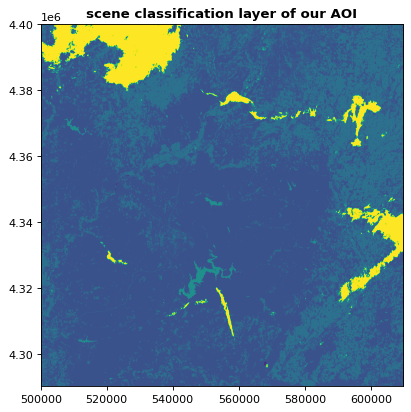

In [24]:
figure(figsize=(8, 6), dpi=80)

tiff = rasterio.open(least_cloudy_item.assets['SCL'].href)
rasterio.plot.show(tiff, title = "scene classification layer of our AOI")

In [25]:
SCL_href = least_cloudy_item.assets['SCL'].href
SCL_band = rioxarray.open_rasterio(pc.sign(SCL_href))
SCL_array = SCL_band.to_numpy()
SCL_band

<xarray.DataArray (band: 1, y: 5490, x: 5490)>
array([[[5, 5, ..., 5, 5],
        [5, 5, ..., 5, 5],
        ...,
        [5, 5, ..., 4, 4],
        [5, 5, ..., 4, 4]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5e+05 5e+05 ... 6.097e+05 6.098e+05 6.098e+05
  * y            (y) float64 4.4e+06 4.4e+06 4.4e+06 ... 4.29e+06 4.29e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

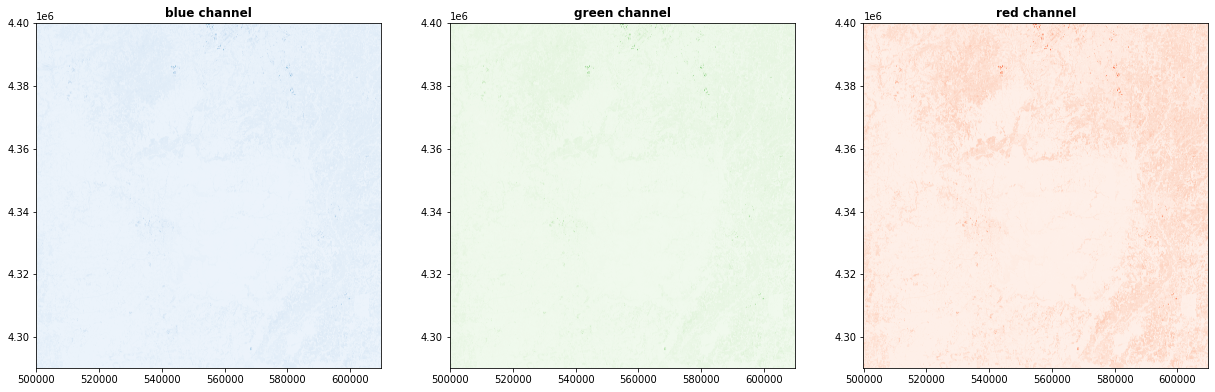

In [26]:
from matplotlib import pyplot
fig, (axb, axg, axr) = pyplot.subplots(1,3, figsize=(21,7))

blue_tiff = rasterio.open(least_cloudy_item.assets['B02'].href)
green_tiff = rasterio.open(least_cloudy_item.assets['B03'].href)
red_tiff = rasterio.open(least_cloudy_item.assets['B04'].href)
rasterio.plot.show(blue_tiff, ax=axb, cmap='Blues', title='blue channel')
rasterio.plot.show(green_tiff, ax=axg, cmap='Greens', title='green channel')
rasterio.plot.show(red_tiff, ax=axr, cmap='Reds', title='red channel')

In [27]:
asset_href = least_cloudy_item.assets['visual'].href
visual_band = rioxarray.open_rasterio(pc.sign(asset_href))
visual_band.to_numpy().mean(axis=(1, 2)).tolist()



[88.76847247520745, 97.56264065149087, 64.24140667250606]

(array([2.4560605e+07, 1.0744514e+08, 7.8863010e+07, 4.0280533e+07,
        3.2220340e+07, 2.7706584e+07, 2.0244303e+07, 1.3058282e+07,
        9.3961670e+06, 7.9062360e+06]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

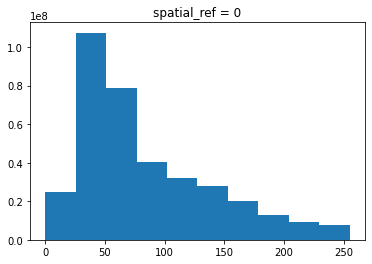

In [28]:
visual_band.plot()

In [29]:
from IPython.display import Image

Image(url=least_cloudy_item.assets["rendered_preview"].href)


In [30]:
import tifffile
raster_image = rioxarray.open_rasterio(pc.sign(least_cloudy_item.assets["visual"].href))

tifffile.imsave('big_image.tif', raster_image)

<ipython-input-30-844613be0ed4>:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave('big_image.tif', raster_image)


In [31]:
def get_aoi_2(lon, lat, delta):
    c1 = [lon + delta, lat + delta]
    c2 = [lon + delta, lat - delta]
    c3 = [lon - delta, lat - delta]
    c4 = [lon - delta, lat + delta]
    geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
    return geometry

geom = get_aoi_2(-86.430867,39.080319, 0.011)
geom

{'type': 'Polygon',
 'coordinates': [[[-86.41986700000001, 39.091319000000006],
   [-86.41986700000001, 39.069319],
   [-86.441867, 39.069319],
   [-86.441867, 39.091319000000006],
   [-86.41986700000001, 39.091319000000006]]]}

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


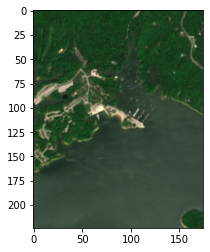

In [32]:
from rasterio.mask import mask

with rasterio.open('/content/big_image.tif') as src:
    # Create a Polygon object to define the AOI
    aoi, min_lat, max_lat, min_lon, max_lon = get_aoi(-86.430867,39.080319, 0.01)
    
    image = raster_image.rio.clip_box(
        minx=min_lat,
        miny=min_lon,
        maxx=max_lat,
        maxy=max_lon,
        crs="EPSG:4326",)
    image.to_numpy()

    # Visualize the clipped raster image
    # plt.imshow(out_image, transform=out_transform)
    # plt.show()
    plt.imshow(np.transpose(image, axes=[1, 2, 0]))
    # Save the output image
    # with rasterio.open("clipped_image.tif", "w", driver="GTiff",
    #                    height=out_image.shape[1], width=out_image.shape[2],
    #                    count=out_image.shape[0], transform=out_transform,
    #                    crs=src.crs) as dst:
    #     dst.write(out_image)